<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Metrics</a></span></li><li><span><a href="#Auto-Regression-(AR)" data-toc-modified-id="Auto-Regression-(AR)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Auto Regression (AR)</a></span><ul class="toc-item"><li><span><a href="#LLR-Test" data-toc-modified-id="LLR-Test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LLR Test</a></span></li><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train/Test Split</a></span></li></ul></li><li><span><a href="#Moving-Average-(MA)" data-toc-modified-id="Moving-Average-(MA)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moving Average (MA)</a></span><ul class="toc-item"><li><span><a href="#Best-MA-Model" data-toc-modified-id="Best-MA-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Best MA Model</a></span></li></ul></li><li><span><a href="#Auto-Regression-and-Moving-Average-(ARMA)" data-toc-modified-id="Auto-Regression-and-Moving-Average-(ARMA)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Auto Regression and Moving Average (ARMA)</a></span><ul class="toc-item"><li><span><a href="#Finding-Best-Orders" data-toc-modified-id="Finding-Best-Orders-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Finding Best Orders</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>ARIMA</a></span><ul class="toc-item"><li><span><a href="#How-to-find-differencing-term?" data-toc-modified-id="How-to-find-differencing-term?-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>How to find differencing term?</a></span></li><li><span><a href="#Grid-Search" data-toc-modified-id="Grid-Search-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Grid Search</a></span></li></ul></li></ul></li><li><span><a href="#Seasonal-ARIMA-(SARIMA)" data-toc-modified-id="Seasonal-ARIMA-(SARIMA)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Seasonal ARIMA (SARIMA)</a></span></li><li><span><a href="#Using-Monthly-Average-instead-of-Daily-Data" data-toc-modified-id="Using-Monthly-Average-instead-of-Daily-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Using Monthly Average instead of Daily Data</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Introduction
Hello there, this is the part 5 of Python for Stock Market Analysis and in this part, we will continue from where we left i.e. modeling a timeseries. Finding a best set of parameters that gives highly accurate prediction is always a hard job and there is not always a guarantee that one can find the best parameters. There are few reasons due to which we can not find best parameters of timeseries model:
* Series can be resembling white noise.
* Series can be random walk.
* External variables (Exogenous) could be in action.

But with assuming that we are ready to break above problems, lets get into modeling.

In [1]:
import pandas as pd
import plotly.express as px
import cufflinks
import plotly.io as pio 
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
warnings.filterwarnings("ignore")
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
pio.renderers.default = "notebook" # should change by looking into pio.renderers
sns.set(rc={'figure.figsize':(40, 20)})
plt.rc("figure", figsize=(16,8))
pd.options.display.max_columns = None

In [2]:
symbols = ["AAPL"]

df = yf.download(tickers=symbols,start="2002-02-01")
df.columns = [c.lower() for c in df.columns]
df.rename(columns={"adj close":"adj_close"},inplace=True)
df.head()

NumExpr defaulting to 8 threads.


[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Date,,,,,,
2002-01-31,0.431429,0.441607,0.430536,0.441429,0.377984,468445600
2002-02-01,0.434643,0.445714,0.434643,0.435893,0.373244,398305600
2002-02-04,0.434286,0.455714,0.432143,0.452679,0.387617,522373600
2002-02-05,0.448036,0.463929,0.447857,0.454464,0.389146,456887200
2002-02-06,0.457143,0.463929,0.431250,0.440536,0.377220,597576000


## Metrics

In [3]:
def percentage_change(forecast, actual, threshold=10):
    pchange = 100*(forecast-actual)/actual
    acc = (pchange.abs()<threshold).sum()/len(pchange)
    return acc

def mean_squared(forecast, actual):
    return np.mean((forecast - actual)**2)

## Auto Regression (AR)
Auto regression is nothing more than a linear relationship of a series with lagged version of itself. 

Formula to represent AR model is:

$$
x_t = c + \phi.x_{(t-1)} + \epsilon_t
$$
Where, 
* c is constant.
* xt is the current value.
* x_(t-1) is the value of previous period.
* 𝜖𝑡 is the residual value.

> If data is from non stationarity process then AR models fails.

The value of lag should be chosen by examining the PACF plot i.e choose last significant value of lag before it becomes insignificant.

[]

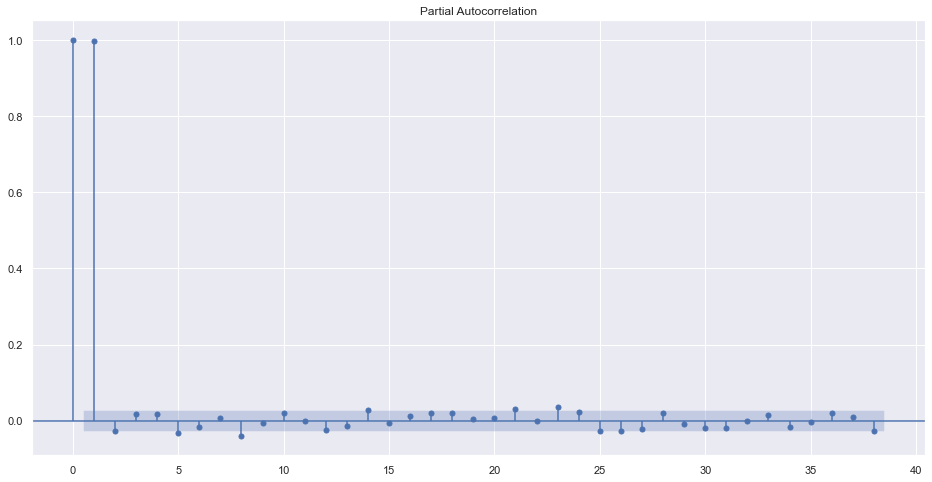

In [4]:
plot_pacf(df.adj_close)
plt.plot()

It seems that after the first lag, the values became insignificant. So the best order of AR can be 1.

### LLR Test
To check if two models are significantly different or not. If the p-value is lower than 5%, then we should choose the later model. Always use simpler model at first. The degree of freedom is chosen by subtracting order values.

In [5]:
from scipy.stats.distributions import chi2

def LLR_test(mod1, mod2, degf=1):
    l1 = mod1.fit().llf
    l2 = mod2.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, degf).round(3)
    
    return p

In [6]:
rmodel1 = ARMA(df.adj_close, order=(1, 0)) 
rresults1 = rmodel1.fit()
print(rresults1.summary())

rmodel3 = ARMA(df.adj_close, order=(2, 0)) 
rresults3 = rmodel3.fit()
print(rresults3.summary())

LLR_test(rmodel1, rmodel3, 1)

                              ARMA Model Results                              
Dep. Variable:              adj_close   No. Observations:                 5088
Model:                     ARMA(1, 0)   Log Likelihood               -6715.633
Method:                       css-mle   S.D. of innovations              0.904
Date:                Sat, 16 Apr 2022   AIC                          13437.266
Time:                        12:59:22   BIC                          13456.870
Sample:                             0   HQIC                         13444.131
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.7966        nan        nan        nan         nan         nan
ar.L1.adj_close     1.0000        nan        nan        nan         nan         nan
                                

0.011

It seems that the model with order 2 is slightly more significant than of order 1. But lets check with 3rd order and second.

In [7]:
rmodel1 = ARMA(df.adj_close, order=(2, 0)) 
rresults1 = rmodel1.fit()
print(rresults1.summary())

rmodel3 = ARMA(df.adj_close, order=(3, 0)) 
rresults3 = rmodel3.fit()
print(rresults3.summary())

LLR_test(rmodel1, rmodel3, 1)

                              ARMA Model Results                              
Dep. Variable:              adj_close   No. Observations:                 5088
Model:                     ARMA(2, 0)   Log Likelihood               -6712.381
Method:                       css-mle   S.D. of innovations              0.903
Date:                Sat, 16 Apr 2022   AIC                          13432.761
Time:                        12:59:24   BIC                          13458.900
Sample:                             0   HQIC                         13441.914
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.7475        nan        nan        nan         nan         nan
ar.L1.adj_close     0.9611   7.05e-06   1.36e+05      0.000       0.961       0.961
ar.L2.adj_close     0.0389   7.3

0.179

It is not significant. Thus we will choose the order of 1 or 2. Lets see the result by making a forecasting.

### Train/Test Split

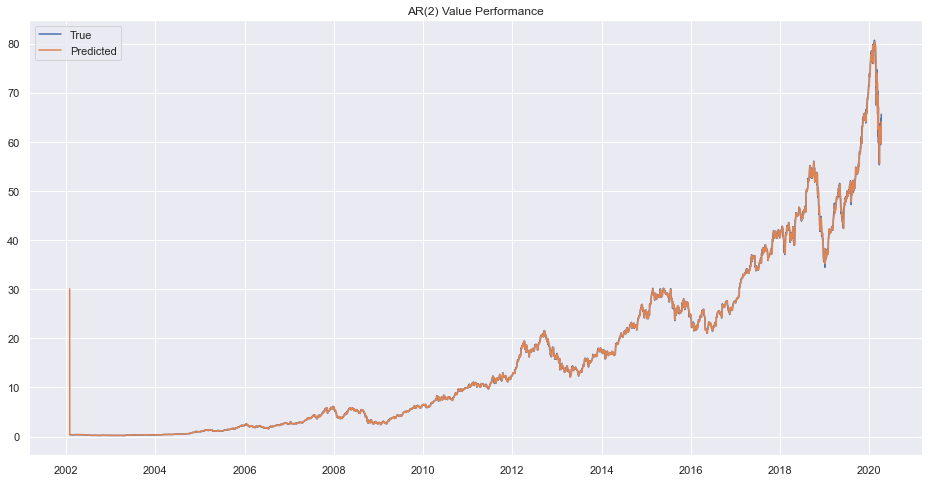

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, shuffle=False)

rrmodel1 = ARMA(train.adj_close, order=(2, 0)) 
rrresults1 = rrmodel1.fit()
# print(rresults1.summary())

# rrresults1.plot_predict(dynamic=False)
# plt.title("AR(2) Model Difference Performance")
# plt.show()


prd = rrresults1.predict()

plt.plot(train.adj_close)
plt.plot(prd)
plt.legend(["True", "Predicted"])
plt.title("AR(2) Value Performance")
plt.show()


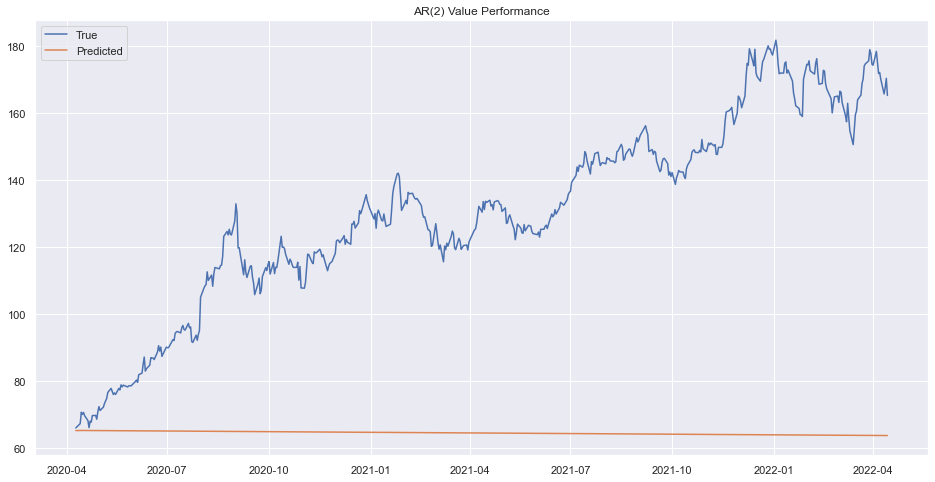

In [9]:
prd=rrresults1.forecast(steps=len(test))[0]
prd = pd.Series(prd, index=test.index)

plt.plot(test.adj_close)
plt.plot(prd)
plt.legend(["True", "Predicted"])
plt.title("AR(2) Value Performance")
plt.show()


Prediction on train set was okay but not in the test set. lets try another order.

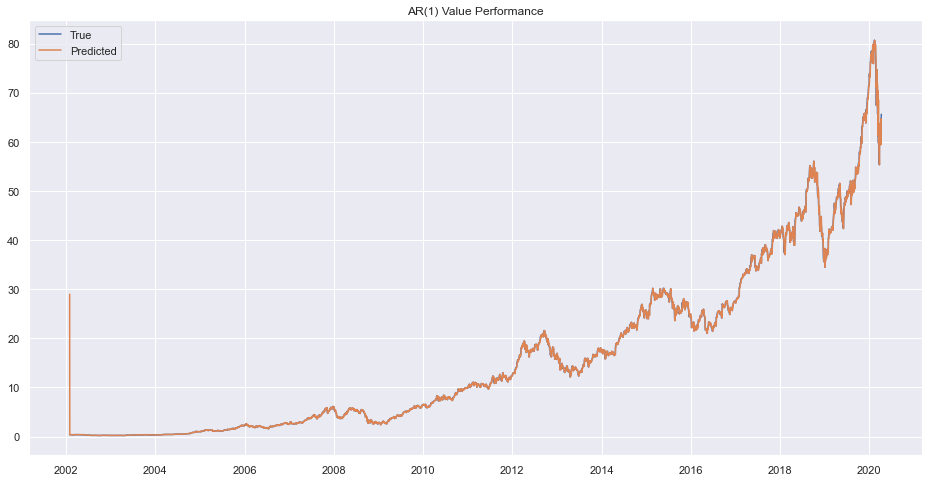

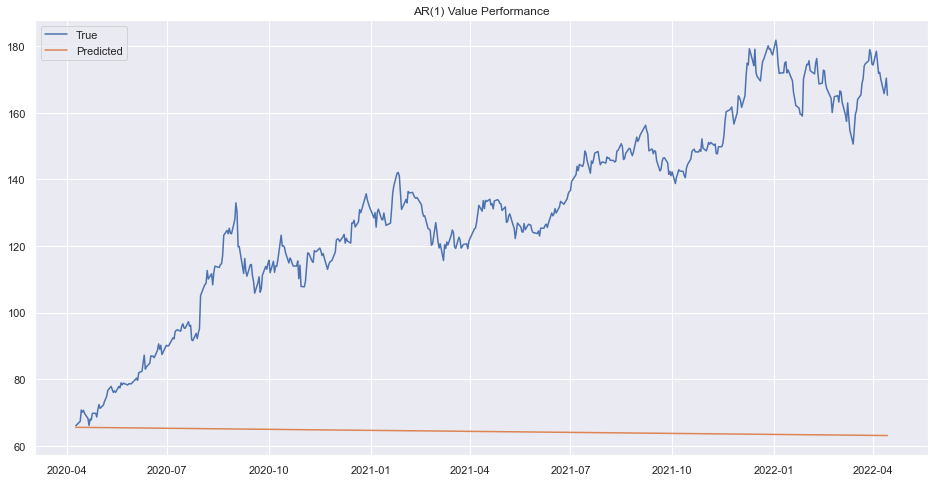

In [10]:
rrmodel1 = ARMA(train.adj_close, order=(1, 0)) 
rrresults1 = rrmodel1.fit()

prd = rrresults1.predict()

plt.plot(train.adj_close)
plt.plot(prd)
plt.legend(["True", "Predicted"])
plt.title("AR(1) Value Performance")
plt.show()

prd=rrresults1.forecast(steps=len(test))[0]
prd = pd.Series(prd, index=test.index)

plt.plot(test.adj_close)
plt.plot(prd)
plt.legend(["True", "Predicted"])
plt.title("AR(1) Value Performance")
plt.show()



The result is bad. Lets try to find Moving Average Model.

## Moving Average (MA)
We have written a good blog about MA in first part of this blog series please refer it for how MA is best idea to look into.

Just like AR model, MA model also uses lag term which is determined using the ACF plot. 
$$
r_t = c + \theta_1.\epsilon_{t-1} + \epsilon_t
$$
Where,
* rt, is value in current period.
* theta, what part of the error last period is relevant in explaining the current value.
* epsilon, error terms of respective time periods.

MA(1) is nearly identical to AR(inf). We can find order of MA using ACF plot.

[]

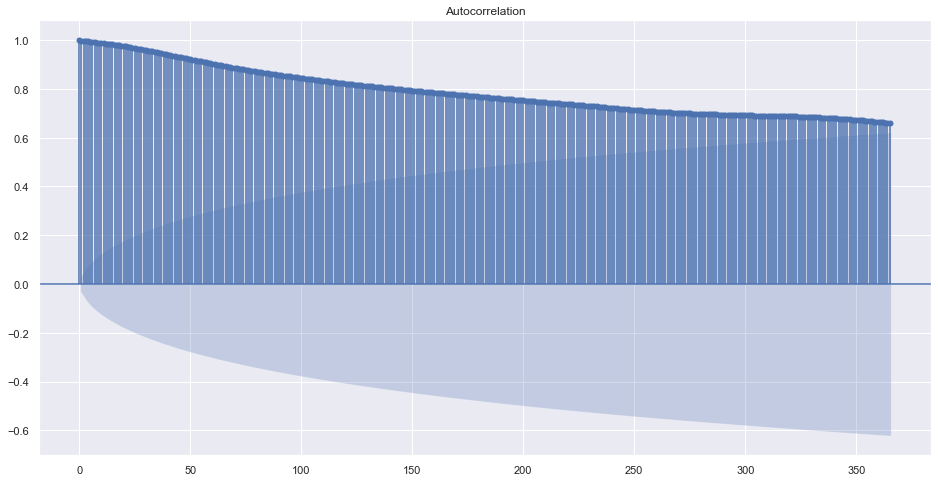

In [11]:
plot_acf(train.adj_close, lags=365)
plt.plot()

The order of MA is hard to find here because there is not a significant changes but slow decrease of correlation. May be because this is a daily data. What happens in a monthly average?

[]

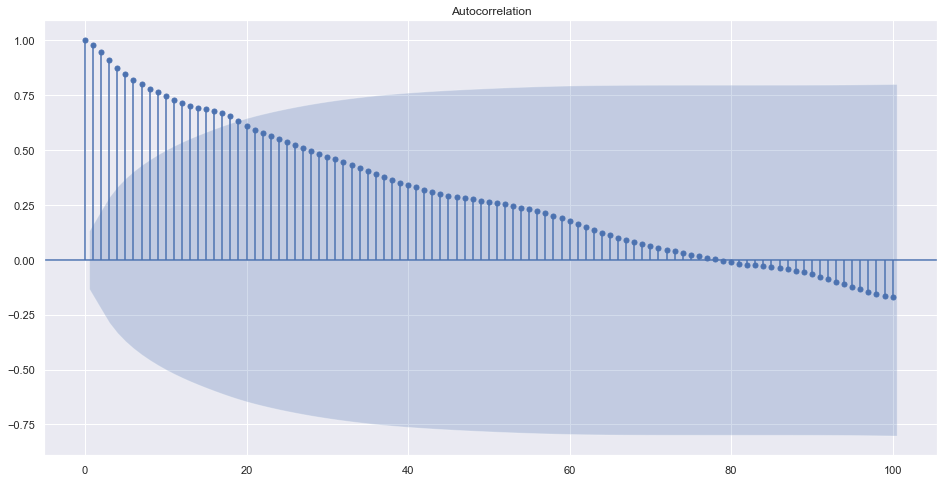

In [12]:
plot_acf(train.resample("1M").adj_close.mean(), lags=100)
plt.plot()

Now we can see that the best order can be below 20 and choices are from 1. ARMA(0,1) is MA(1).

### Best MA Model

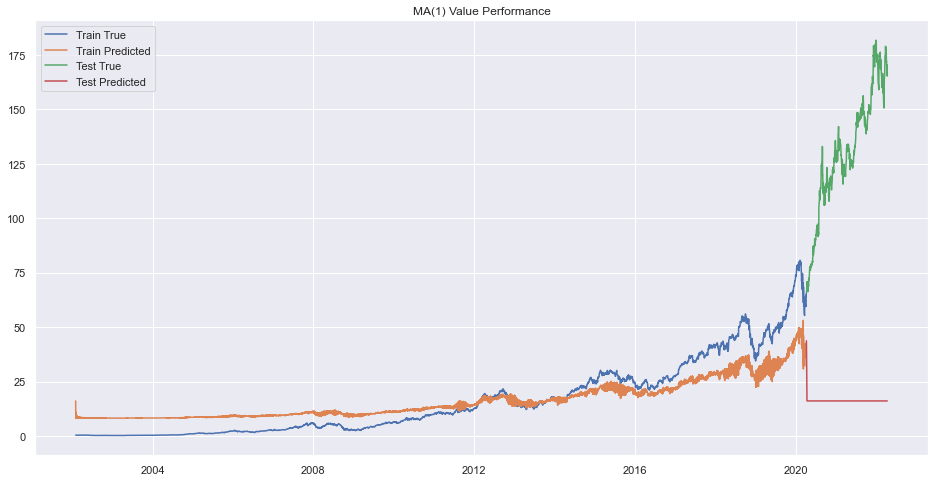

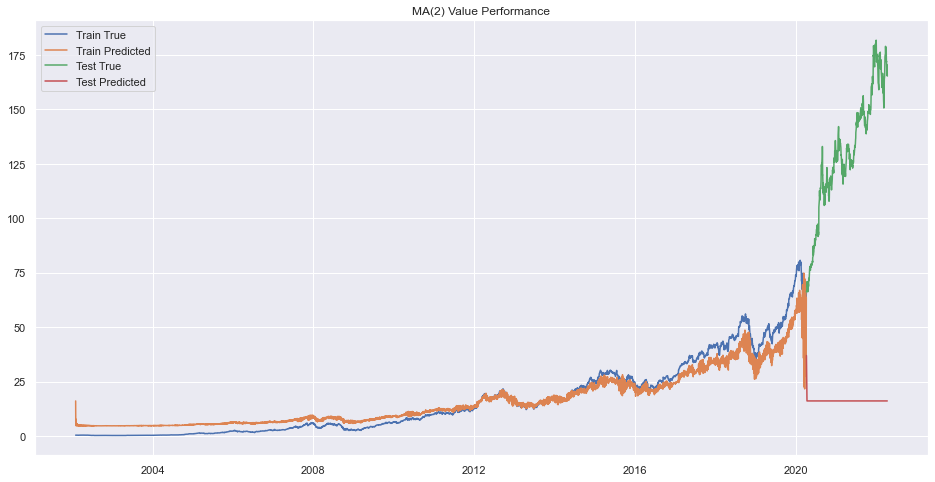

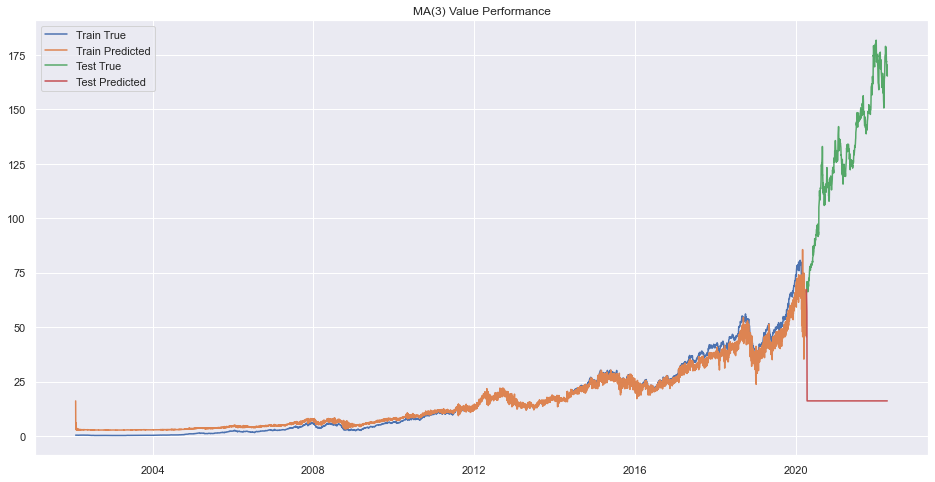

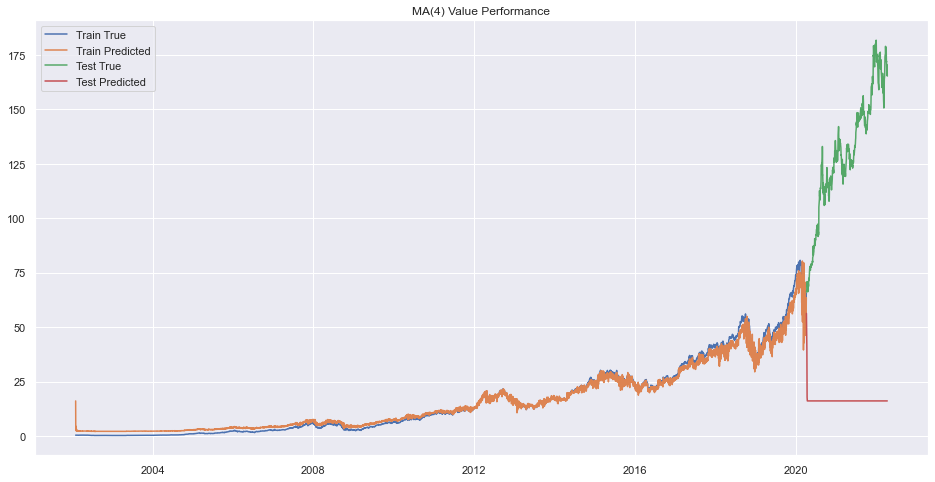

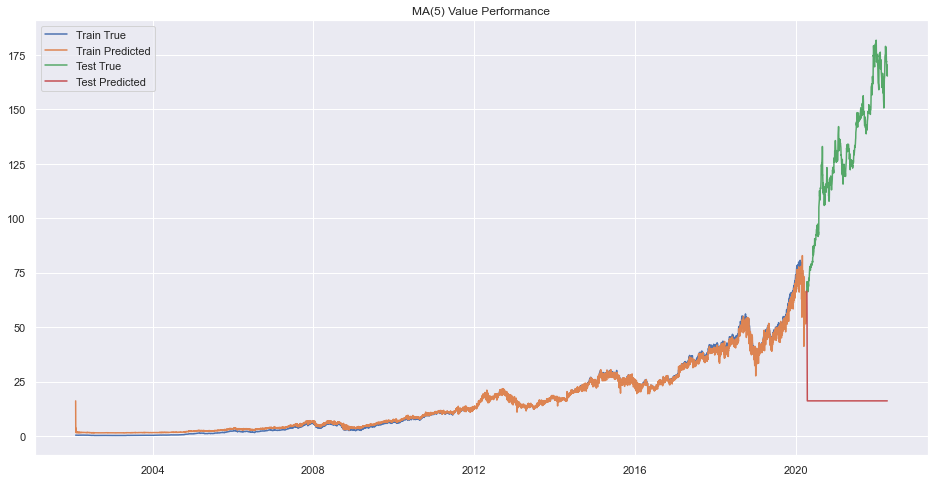

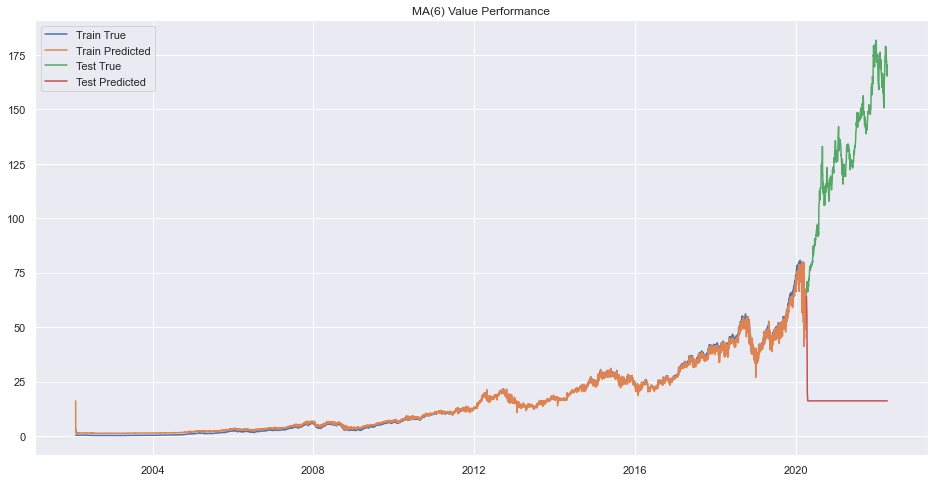

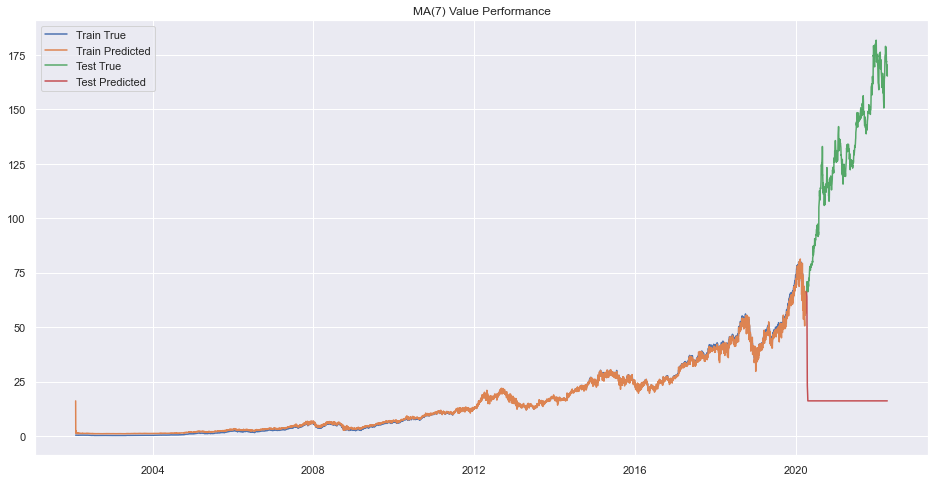

Error on order 8


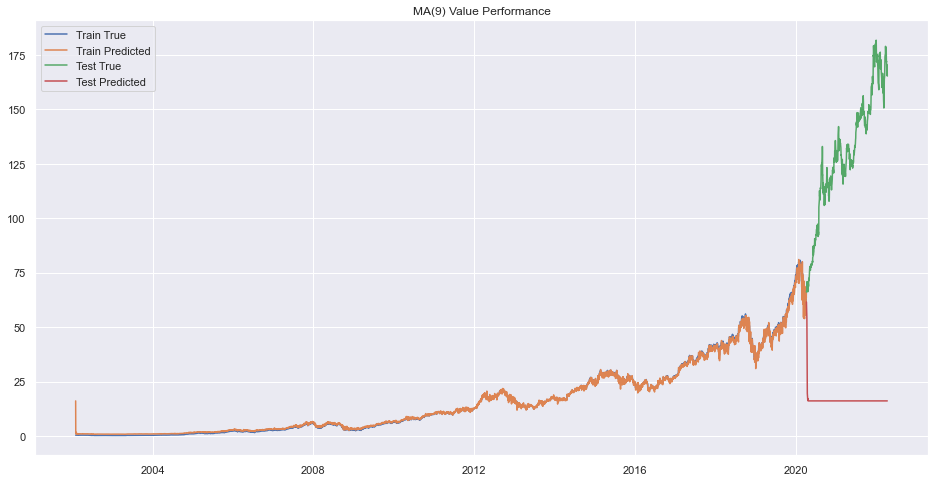

In [13]:
best=None
pq = 0
for q in range(1,10):    
    try:
        model1 = ARMA(train.adj_close, order=(0, q))
        
        rrresults1 = model1.fit()
        if best is None:
            best=model1
            pq=q
        else:
            if LLR_test(best, model1, q-pq)<0.05:
                best=model1
                pq=q

        prd = rrresults1.predict()

        plt.plot(train.adj_close)
        plt.plot(prd)

        prd=rrresults1.forecast(steps=len(test))[0]
        prd = pd.Series(prd, index=test.index)

        plt.plot(test.adj_close)
        plt.plot(prd)

        plt.legend(["Train True", "Train Predicted", "Test True", "Test Predicted"])
        plt.title(f"MA({q}) Value Performance")
        plt.show()
    except:
        print(f"Error on order {q}")

In [14]:
print(f"Best Order is {pq}.")

Best Order is 9.


There seems to be very bad forecasting but performance on train data was okay.

## Auto Regression and Moving Average (ARMA)
It is simple a sum of AR and MA model.

ARMA=AR+MA

### Finding Best Orders

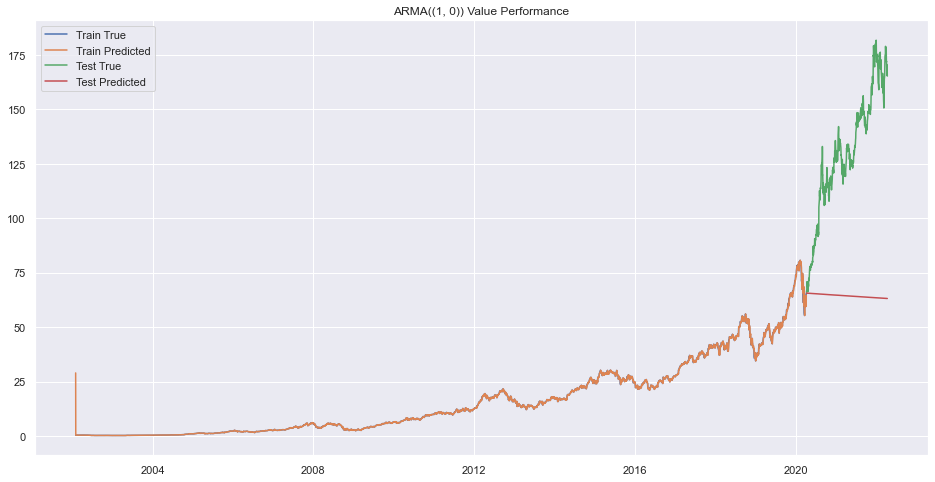

Error on order (1, 1)
Error on order (1, 2)
Error on order (1, 3)
Error on order (1, 4)
Error on order (1, 5)
Error on order (1, 6)
Error on order (1, 7)
Error on order (1, 8)
Error on order (1, 9)


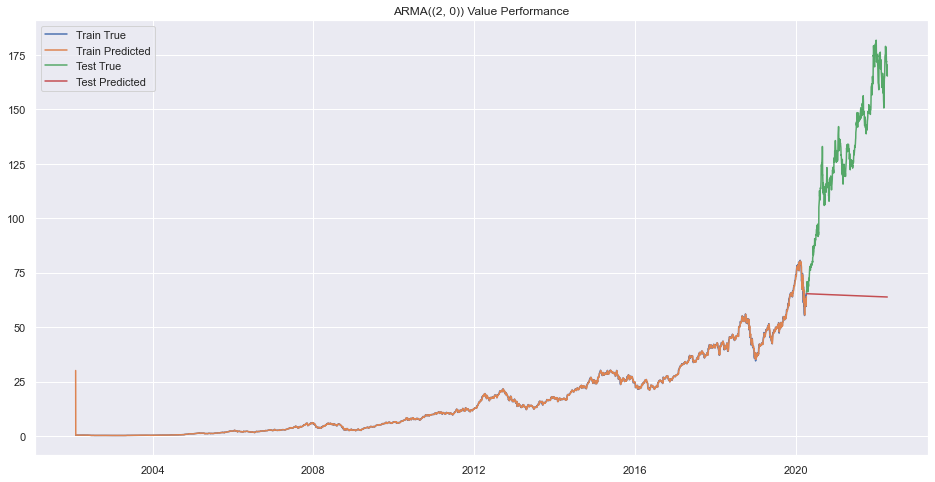

Error on order (2, 1)
Error on order (2, 2)
Error on order (2, 3)
Error on order (2, 4)
Error on order (2, 5)
Error on order (2, 6)
Error on order (2, 7)
Error on order (2, 8)
Error on order (2, 9)


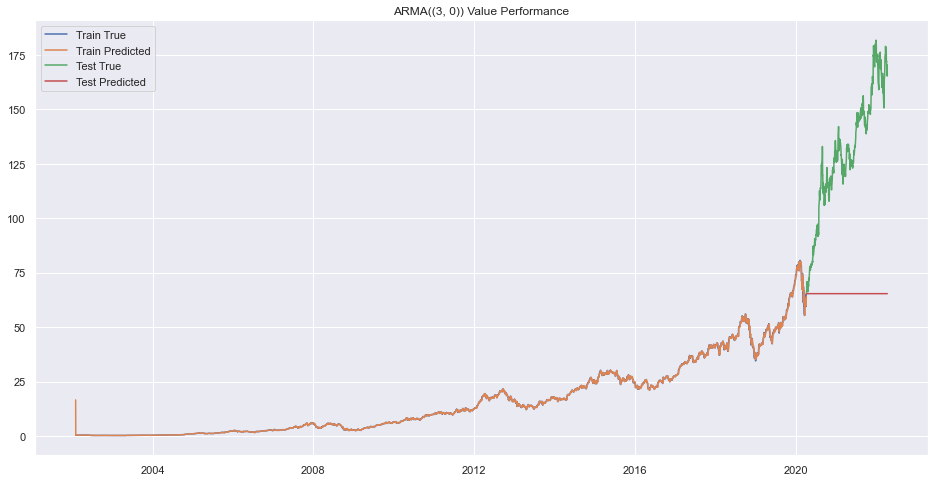

Error on order (3, 1)
Error on order (3, 2)
Error on order (3, 3)
Error on order (3, 4)
Error on order (3, 5)
Error on order (3, 6)
Error on order (3, 7)
Error on order (3, 8)
Error on order (3, 9)


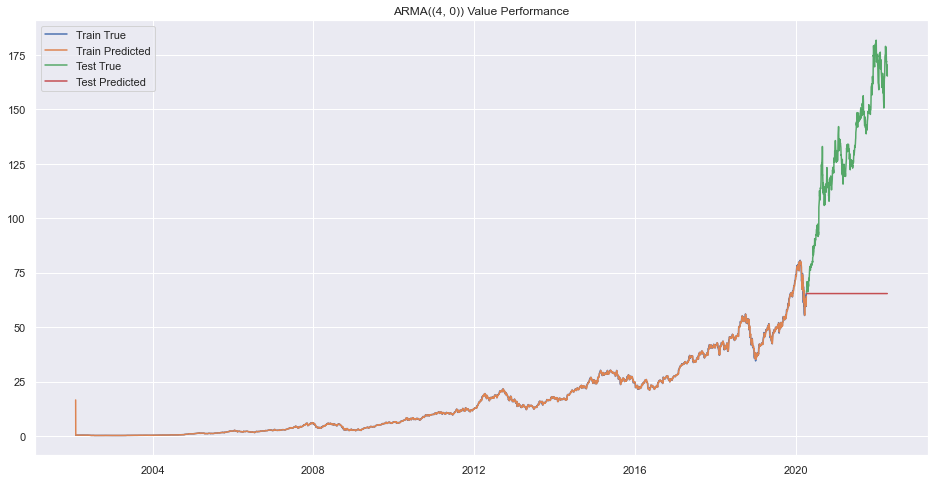

Error on order (4, 1)
Error on order (4, 2)
Error on order (4, 3)
Error on order (4, 4)
Error on order (4, 5)
Error on order (4, 6)
Error on order (4, 7)
Error on order (4, 8)
Error on order (4, 9)


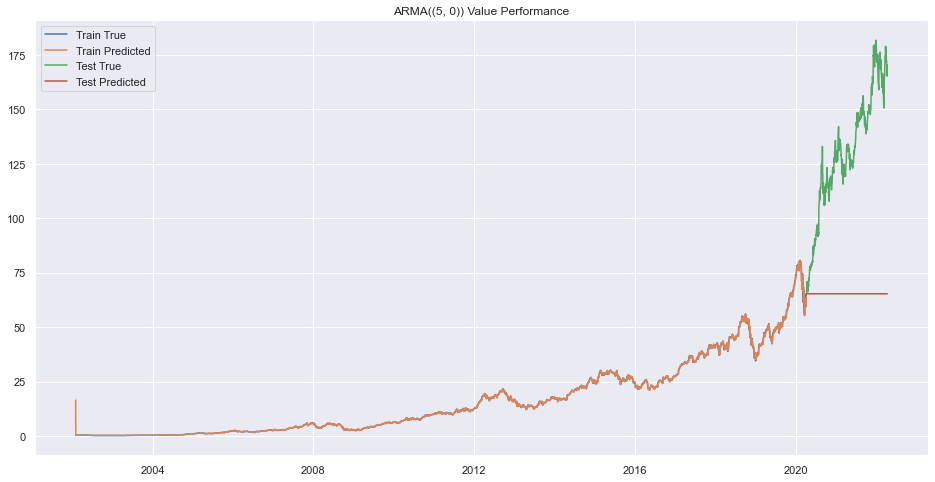

Error on order (5, 1)
Error on order (5, 2)
Error on order (5, 3)
Error on order (5, 4)
Error on order (5, 5)
Error on order (5, 6)
Error on order (5, 7)
Error on order (5, 8)
Error on order (5, 9)


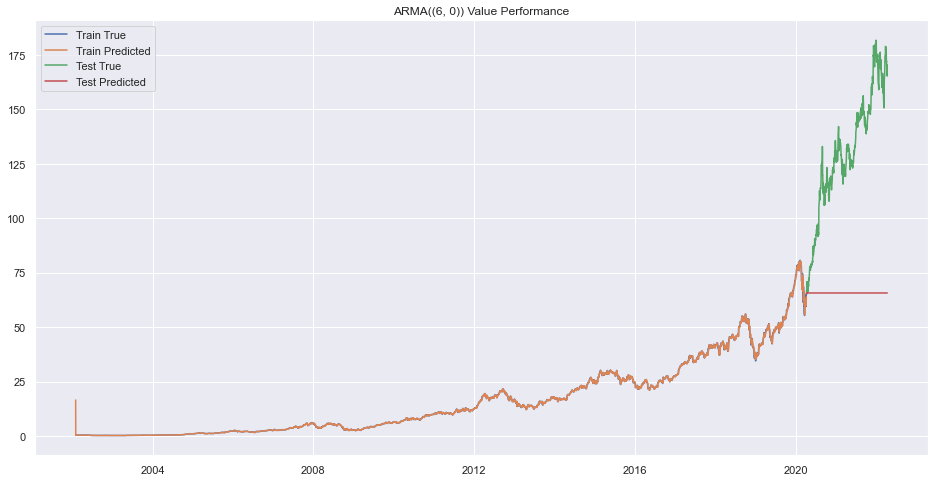

Error on order (6, 1)
Error on order (6, 2)
Error on order (6, 3)
Error on order (6, 4)
Error on order (6, 5)
Error on order (6, 6)
Error on order (6, 7)
Error on order (6, 8)
Error on order (6, 9)


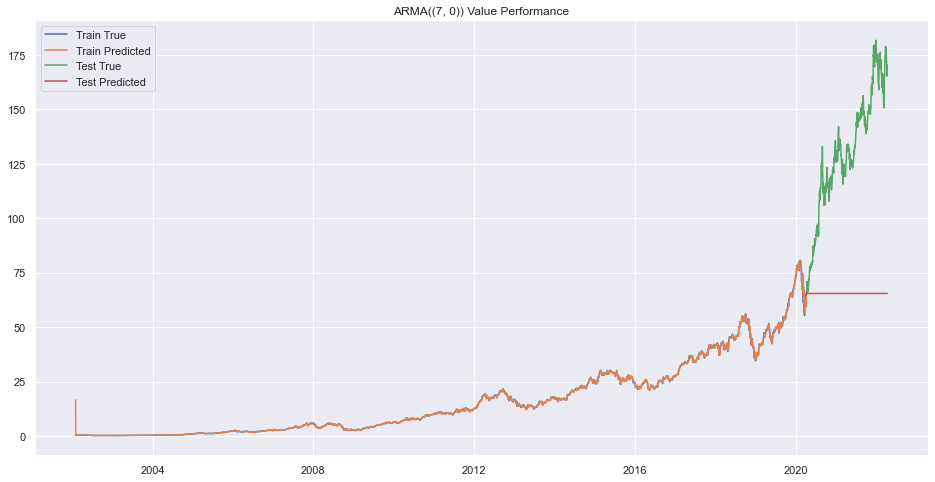

Error on order (7, 1)
Error on order (7, 2)
Error on order (7, 3)
Error on order (7, 4)
Error on order (7, 5)
Error on order (7, 6)
Error on order (7, 7)
Error on order (7, 8)
Error on order (7, 9)


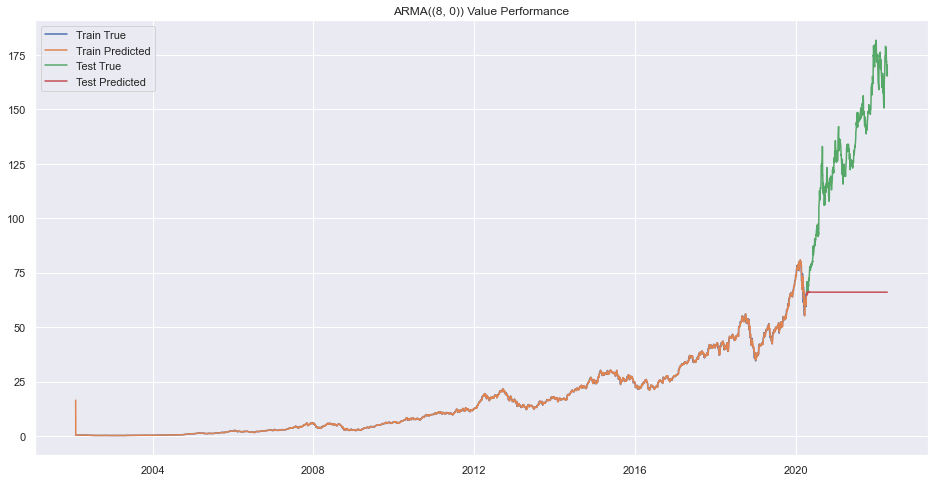

Error on order (8, 1)
Error on order (8, 2)
Error on order (8, 3)
Error on order (8, 4)
Error on order (8, 5)
Error on order (8, 6)
Error on order (8, 7)
Error on order (8, 8)
Error on order (8, 9)


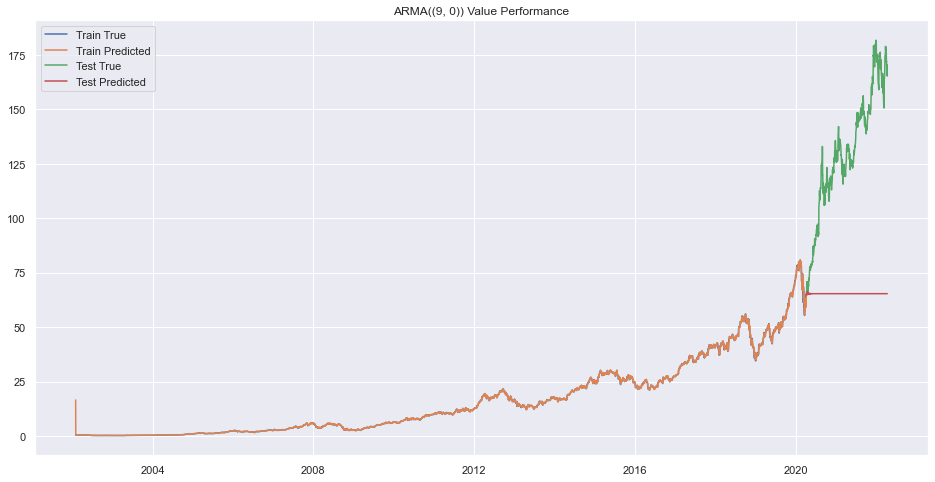

Error on order (9, 1)
Error on order (9, 2)
Error on order (9, 3)
Error on order (9, 4)
Error on order (9, 5)
Error on order (9, 6)
Error on order (9, 7)
Error on order (9, 8)
Error on order (9, 9)


In [15]:
best=None
pq = 0
pp = 0
for p in range(1,10):
    for q in range(10):    
        try:
            model1 = ARMA(train.adj_close, order=(p, q))
            rrresults1 = model1.fit()
            
            if best is None:
                best=model1
                pq=q
                pp = p
            else:
                if LLR_test(best, model1, q-pq)<0.05:
                    best=model1
                    pq=q
                    pp=p

            prd = rrresults1.predict()

            plt.plot(train.adj_close)
            plt.plot(prd)

            prd=rrresults1.forecast(steps=len(test))[0]
            prd = pd.Series(prd, index=test.index)

            plt.plot(test.adj_close)
            plt.plot(prd)

            plt.legend(["Train True", "Train Predicted", "Test True", "Test Predicted"])
            plt.title(f"ARMA({(p,q)}) Value Performance")
            plt.show()
        except Exception as e:
#             raise e
            print(f"Error on order {(p,q)}")

### ARIMA
Add integration feature to the ARMA. It has 3 values as order, (p, d, q) p from AR, d as integrating order and q as MA order.

#### How to find differencing term?

The differencing term is needed only if the data is not stationary. Look at the ACF of different order of value.

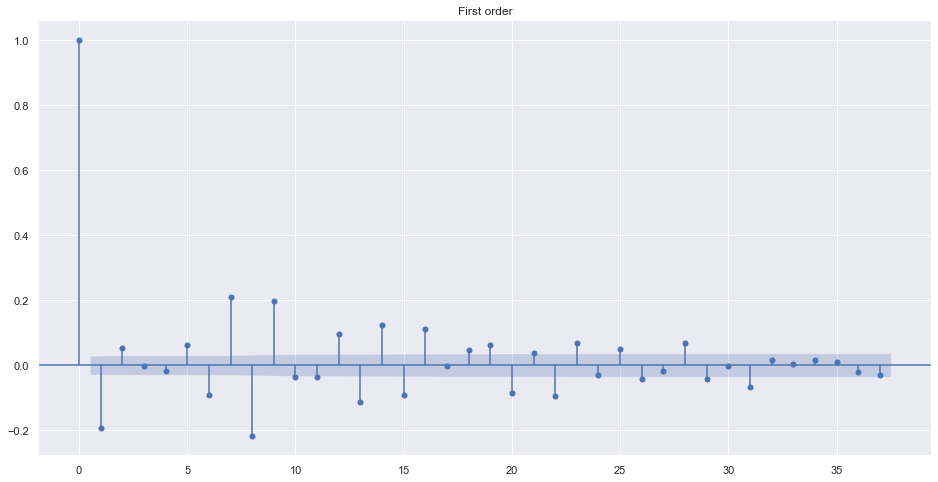

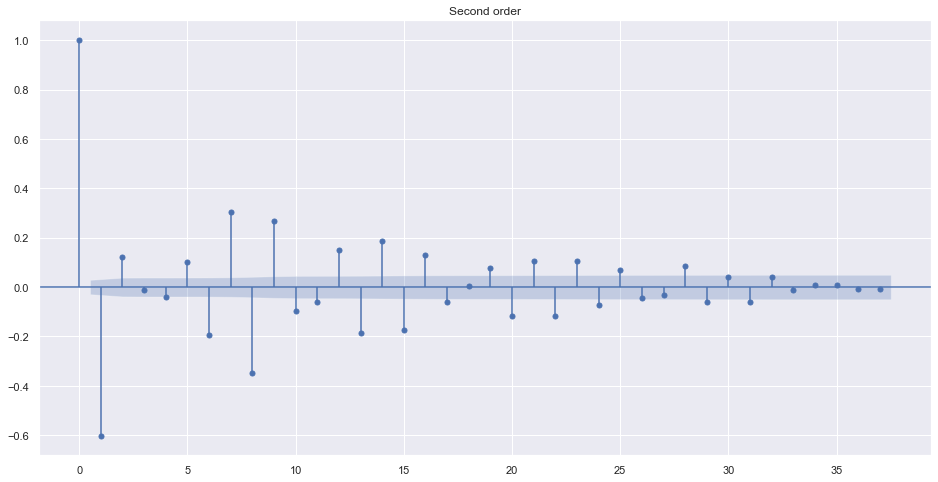

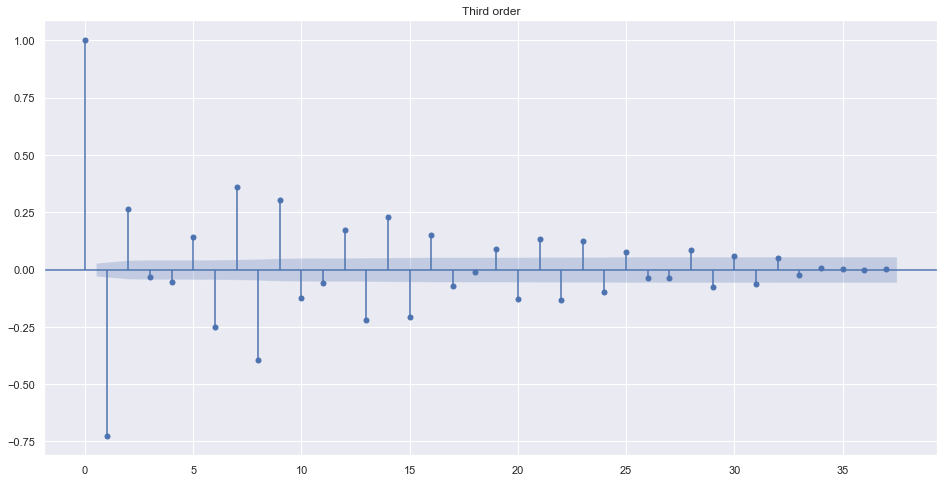

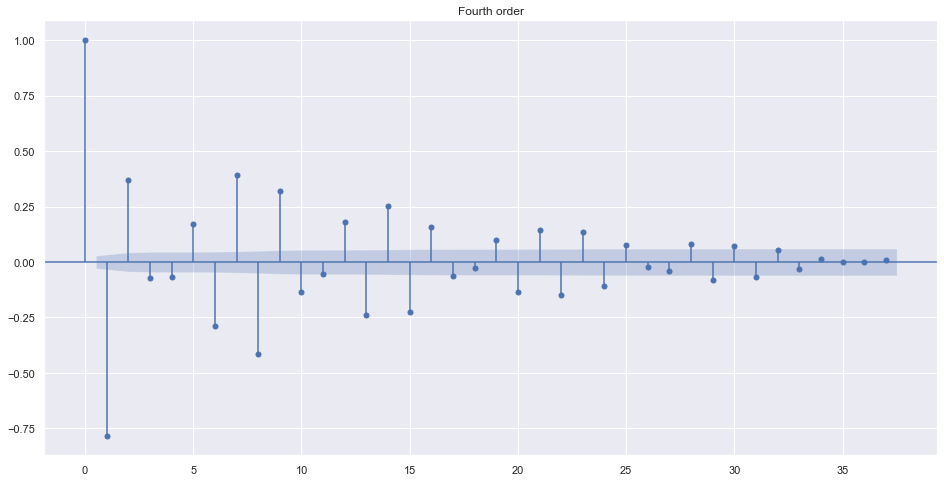

In [16]:
plot_acf(train.adj_close.diff().dropna(), title="First order")
plot_acf(train.adj_close.diff().diff().dropna(), title="Second order")
plot_acf(train.adj_close.diff().diff().diff().dropna(), title="Third order")
plot_acf(train.adj_close.diff().diff().diff().diff().dropna(), title="Fourth order")
plt.show()

Alternatively, we can find best order by looking into ndiffs from `pmdarima`. It uses different algorithms to make data stationary.

In [17]:
from pmdarima.arima.utils import ndiffs

# adf
print(ndiffs(train.adj_close, test='adf')  )

# KPSS test
print(ndiffs(train.adj_close, test='kpss') )

# PP test:
print(ndiffs(train.adj_close, test='pp')  )

1
1
1


#### Grid Search

We will find best order of p,d,q in ARIMA(p,d,q) using GridSearch by manually trying each order and taking the best model as that which have very little AIC (Akaike Information Criterion).

In [19]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = ARIMA(train.adj_close, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                print(f"Order: {(i, d, j)} AIC: {tmp_aic}")
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))



Order: (0, 0, 1) AIC: 35649.957536726
Order: (0, 0, 2) AIC: 30452.926279850846
Order: (0, 0, 3) AIC: 25568.02974006658
Order: (0, 0, 4) AIC: 23135.908151069194
Order: (0, 1, 1) AIC: 6113.786234527973
Order: (0, 1, 2) AIC: 6103.676229595621
Order: (0, 1, 3) AIC: 6105.164302350337
Order: (0, 1, 4) AIC: 6107.097404802813
Order: (0, 2, 1) AIC: 6279.333482578022
Order: (0, 2, 2) AIC: 6116.57706331723
Order: (0, 2, 3) AIC: 6107.231252247981
Order: (0, 2, 4) AIC: 6108.574009581484
Order: (1, 0, 0) AIC: 6286.055625234081
Order: (1, 1, 0) AIC: 6102.620679110958
Order: (1, 1, 1) AIC: 6103.588554384392
Order: (1, 1, 2) AIC: 6062.107525235468
Order: (1, 1, 3) AIC: 6025.035860265804
Order: (1, 1, 4) AIC: 6010.0475679855035
Order: (1, 2, 0) AIC: 8186.521128276045
Order: (1, 2, 1) AIC: 6105.782414442538
Order: (1, 2, 3) AIC: 6064.5909315706185
Order: (1, 2, 4) AIC: 6028.885354842478
Order: (2, 0, 0) AIC: 6114.971431245766
Order: (2, 1, 0) AIC: 6103.477381158474
Order: (2, 1, 1) AIC: 6022.377015689852

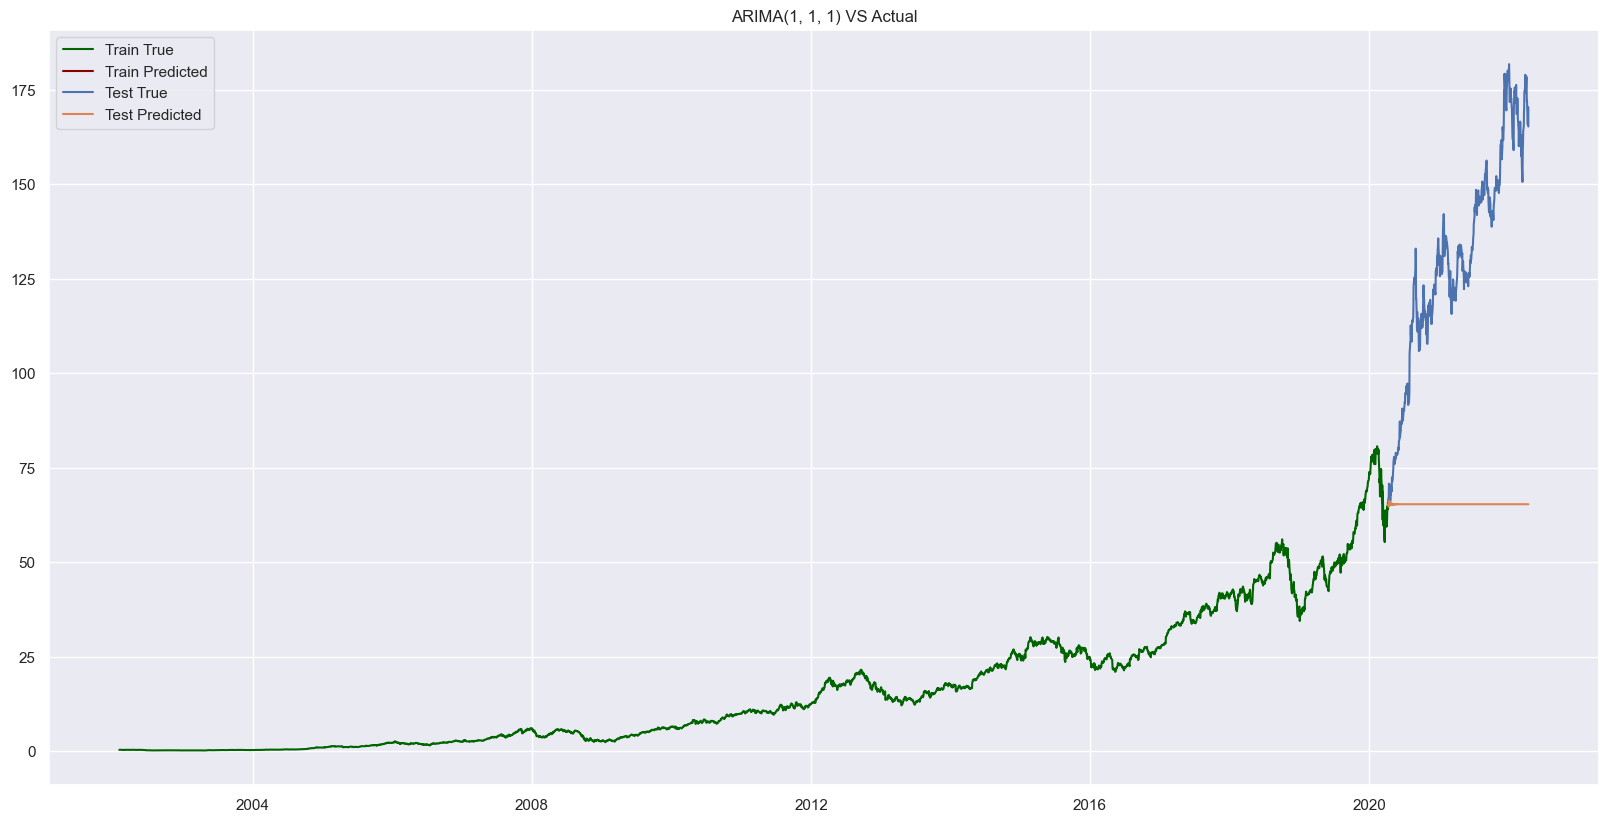

In [31]:
fitted = best_mdl.predict(start=best_order[1], end=len(train))
index_of_fc = train.adj_close.index

fseries = pd.Series(fitted, index=index_of_fc)

#plot
plt.figure(figsize=(20, 10), dpi=100)
plt.plot(train.adj_close, label="Train Actual", color="darkgreen")
plt.plot(fseries, label="Train Forecast", color="darkred")
prd=rrresults1.forecast(steps=len(test))[0]
prd = pd.Series(prd, index=test.index)
plt.plot(test.adj_close, label="Test Actual")
plt.plot(prd, label="Test Predicted")
plt.title(f"ARIMA{best_order} VS Actual")
plt.legend(["Train True", "Train Predicted", "Test True", "Test Predicted"])
plt.show()




# plt.legend(loc='upper left', fontsize=15)
# plt.title(f"ARMA({(p,q)}) Value Performance")


In [32]:
percentage_change(fseries, train.adj_close), percentage_change(prd, test.adj_close)

(0.0, 0.03339882121807466)

Our ARIMA Model did not perform well in forecasting. Lets try to train a SARIMA Model.

## Seasonal ARIMA (SARIMA)
Take seasonality when fitting a model. Use orders already found from previous steps. This model uses seasonal component also.
* SARIMA(p, d, q)(P, D, Q, M)
* D = 0 for stationary data, else the differencing value that makes data stationary.
* P from PACF and Q from ACF.
* The value of M should be chosen from Seasonal Decompose graph.

We know from the ARIMA that best order is (4,1,4) lets use that to find best seasonal parameters.

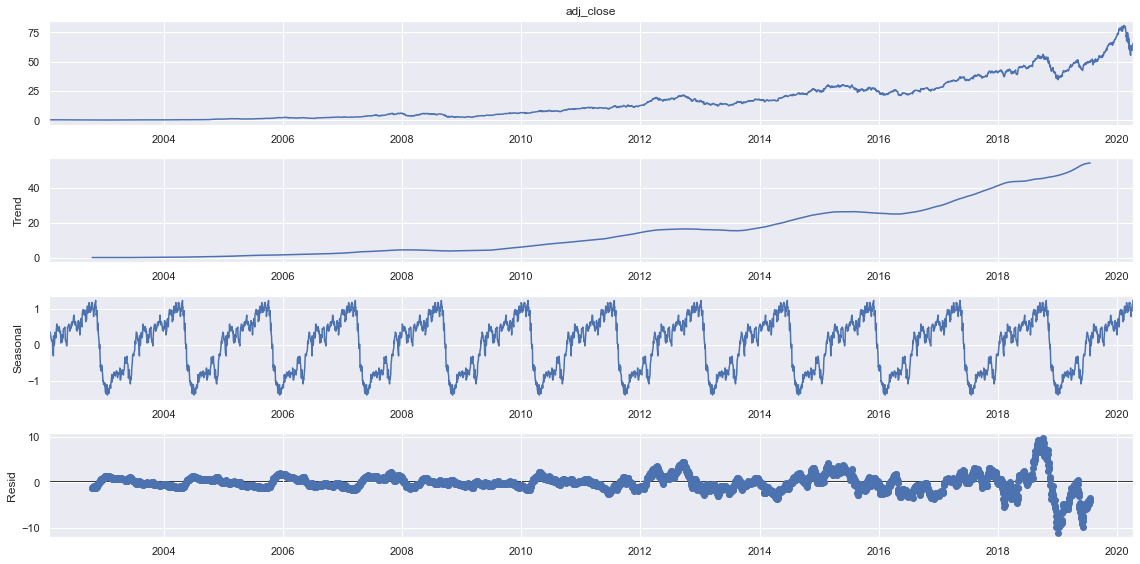

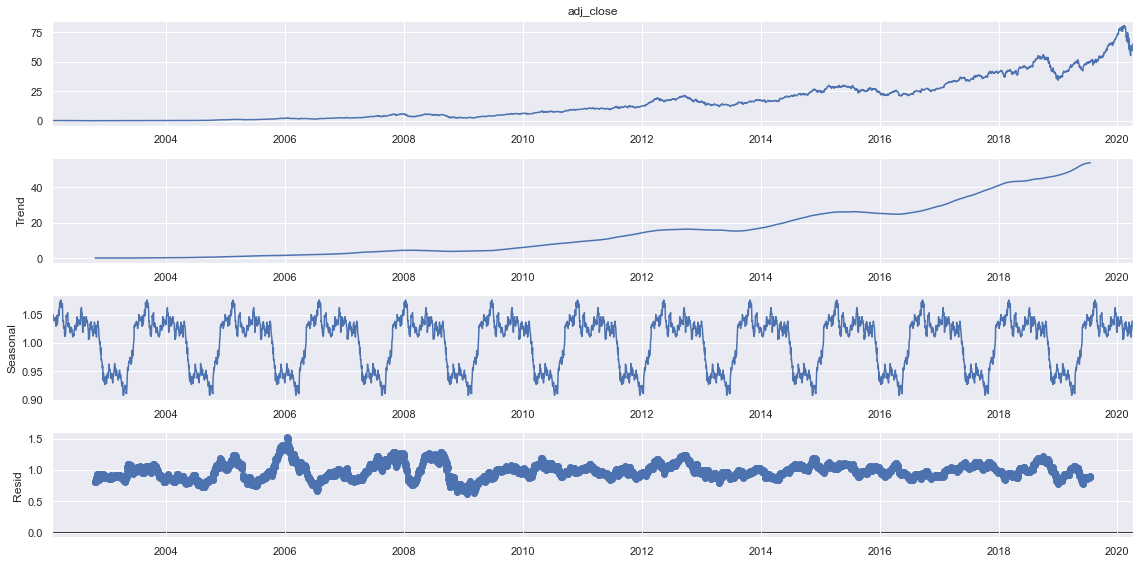

In [34]:
# check for weekly data
from statsmodels.tsa.seasonal import seasonal_decompose
sdec = seasonal_decompose(train.adj_close, model="additive", period=365)
sdec.plot()
plt.show()

sdec = seasonal_decompose(train.adj_close, model="multiplicative", period=365)
sdec.plot()
plt.show()


In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 


order = (4, 1, 4)

best_aic = np.inf
best_mdl = None
ms=[365]
best_order = None
best_sorder = None

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for m in ms:
                try:
                    sorder = (P, D, Q, m)
                    # define a model
                    smodel = SARIMAX(train.adj_close, order=order, seasonal_order=sorder)
                    smodel = smodel.fit()
                    print(f"Order: {order}, Sorder: {sorder}, AIC: {smodel.aic}")
                    if smodel.aic<best_aic:
                        best_aic = smodel.aic
                        best_mdl = smodel
                        best_order = order
                        best_sorder = sorder
                except Exception as e:
                    print(e)
#                 continue

print(f"Best Order: {best_order} Best SOrder: {best_sorder} AIC: {best_mdl.aic}")

Order: (4, 1, 4), Sorder: (0, 0, 0, 365), AIC: 5750.778071206555


KeyboardInterrupt: 

It will take a lot time and will not even find best order. SO, lets use monthly average data instead of daily.

## Using Monthly Average instead of Daily Data 

In [40]:
import pmdarima as pm

mtrain=train.resample("1M").adj_close.mean()
mtest = test.resample("1M").adj_close.mean()

model=pm.auto_arima(mtrain, start_p=0, start_q=0,
                             max_p=5, max_q=5, m=12,
                             start_P=0, seasonal=True,stationary=False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True, maxiter=50) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=982.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=874.988, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=946.930, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=851.648, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=830.994, Time=2.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=830.031, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=830.257, Time=1.78 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=828.257, Time=0.73 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=841.816, Time=0.52 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=821.246, Time=1.01 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=823.23

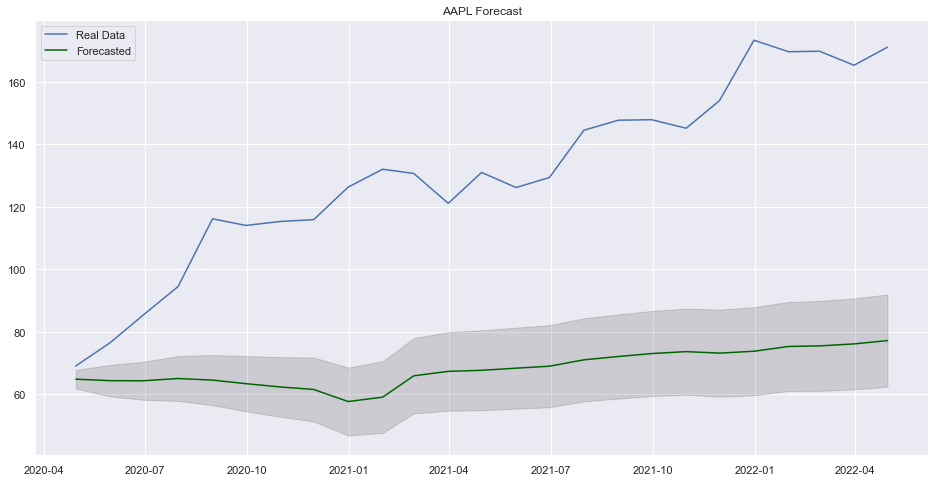

In [43]:
# Forecast
n_periods = len(mtest)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = mtest.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

t = mtest
t.index = index_of_fc
# Plot
plt.plot(t)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(["Real Data", "Forecasted"])

plt.title("AAPL Forecast")
plt.show()

## Conclusion
It seems that our model was able to find some pattern in the test data but it is not near to be good. Using different level of date might be a best idea in this case.